In [1]:
# SEM GPU é muito mais rápido e dá menos erro
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time

log_file = open("output-unet.log","w")

def print_log(*args):
    line = " ".join([str(a) for a in args])
    log_file.write(line+"\n")
    print(line)

training_size:  19 validation_size:  1
epoch completed
shape of the batch (15, 256, 256, 3) (15, 256, 256)
Number of images in the batch:  15


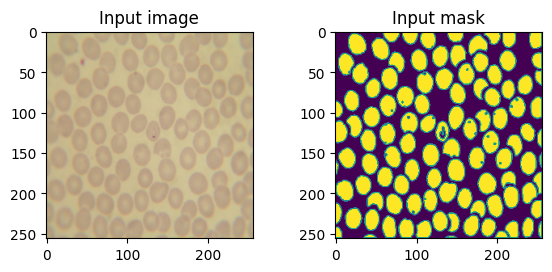

In [3]:
#data generator class
class DataGen(keras.utils.Sequence):
    def __init__(self, train_ids, train_path, batch_size=10, image_size=256, mask_size=None):
        self.ids = train_ids;
        self.path = train_path;
        self.batch_size = batch_size;
        self.image_size = image_size;
        self.mask_size = image_size
        if mask_size != None:
            self.mask_size = mask_size
        
        self.on_epoch_end();
        
    def __load__(self, id_name):
        #defining path for the training data set
        
        id_name_mask = id_name.replace(".JPG",".png").replace(".jpg",".png")
        

        image_path = os.path.join(self.path, "images", id_name);
        mask_path = os.path.join(self.path, "masks", id_name_mask); #mascaras estao em .png
        
        # reading the image from dataset
        ## Reading Image
        image = cv2.imread(image_path); #reading image to image vaiable
        image = cv2.resize(image, (self.image_size, self.image_size));
        mask = cv2.imread(mask_path, 0); #mask image of same size with all zeros
        mask = cv2.resize(mask, (self.image_size ,self.mask_size));
        #mask = np.expand_dims(mask, axis=-1);
        #image normalisation
        image = image / 255.0;
        #mask = mask / 255.0;
        
        mask[mask <= 50] = 0
        mask[np.logical_and(mask > 50, mask < 200)] = 1
        mask[mask >= 200] = 2
        
        return image, mask;
    
    def __getitem__(self, index): #index : batch no.
        
        if(index+1)*self.batch_size > len(self.ids): # redining last batch size
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size] #list of 10 image ids
        
        image = [] #collection of 10 images
        mask  = [] #collection of 10 masks
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name);
            image.append(_img);
            mask.append(_mask);
            
        image = np.array(image);
        mask  = np.array(mask);
        
        return image, mask; #return array of 10 images and 10 masks
    
    #for printing the statistics of the function
    def on_epoch_end(self):
        print_log("epoch completed");
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)));#length of the epoch as length of generation DataGen obj
    
BATCH_SIZE = 15
image_size = 256
mask_size  = None
NUM_EPOCHS = 1000

train_path = "./data-1024x1024-border"; #address of the dataset
train_ids = os.listdir(train_path + "/images")
val_data_size = 1; #size of set of images used for the validation 
valid_ids = train_ids[:val_data_size]; # list of image ids used for validation of result 0 to 9
train_ids = train_ids[val_data_size:]; #list of image ids used for training dataset
print_log("training_size: ", len(train_ids), "validation_size: ", len(valid_ids))

#making generator object
gen = DataGen(train_ids, train_path, BATCH_SIZE, image_size, mask_size=mask_size);

#Analysing sample of the dataset from data generator
#getting image_set data from dataset
x, y = gen.__getitem__(0); # self = gen and index = 0 each item is a set of 8 images
print_log("shape of the batch", x.shape, y.shape);
print_log("Number of images in the batch: ", len(x));

#display of the sample of the data zeroth image
fig = plt.figure();
fig.subplots_adjust(hspace=0.4, wspace=0.4); #reserving height above plot and space between plots
ax = fig.add_subplot(1, 2, 1); #figure of 1 row 2 columns and 1st image
x1 = (x[2]*255).astype(np.uint8);
x1 = cv2.cvtColor(x1, cv2.COLOR_BGR2RGB);
ax.imshow(x1);
plt.title("Input image");

ax = fig.add_subplot(1, 2, 2); #2nd image plot
ax.imshow(y[2]);
plt.title("Input mask");

In [4]:
def double_conv_block(x, n_filters):
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    return x

def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p

def upsample_block(x, conv_features, n_filters):
    # upsample
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate
    x = layers.concatenate([x, conv_features])
    # dropout
    x = layers.Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)
    return x

def build_unet_model(input_size=(128,128,3)):
    # inputs
    inputs = layers.Input(shape=input_size)
    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)
    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)
    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)
    # outputs
    #outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)
    outputs = layers.Conv2D(3, 1, padding="same", activation = "sigmoid")(u9)
    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    return unet_model


unet_model = build_unet_model(input_size = (image_size,image_size,3))

unet_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

                                                                                                  
 conv2d_14 (Conv2D)             (None, 128, 128, 12  295040      ['dropout_6[0][0]']              
                                8)                                                                
                                                                                                  
 conv2d_15 (Conv2D)             (None, 128, 128, 12  147584      ['conv2d_14[0][0]']              
                                8)                                                                
                                                                                                  
 conv2d_transpose_3 (Conv2DTran  (None, 256, 256, 64  73792      ['conv2d_15[0][0]']              
 spose)                         )                                                                 
                                                                                                  
 concatena

In [5]:
save_period = 50
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=BATCH_SIZE);
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=BATCH_SIZE);
print_log("total training batches: ", len(train_gen));
print_log("total validaton batches: ", len(valid_gen));
STEPS_PER_EPOCH = len(train_ids)//BATCH_SIZE;
VALIDATION_STEPS = len(valid_ids)//BATCH_SIZE;
print_log("image_size:", image_size)
print_log("epochs:",NUM_EPOCHS)
print_log("save_period:",save_period)
versao = 1

_fileName = "./unet2-s%d-e%d-v%d-tf241-comborda-sig.h5"
filename = _fileName % (image_size, NUM_EPOCHS, versao)

print_log("filename:",filename)

epoch completed
epoch completed
total training batches:  2
total validaton batches:  1
image_size: 256
epochs: 1000
save_period: 50
filename: ./unet2-s256-e1000-v1-tf241-comborda-sig.h5


In [6]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics="accuracy")

cp_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath="unet2-checkpoint.h5", 
        verbose=1, 
        save_weights_only=True,
        save_freq=save_period*STEPS_PER_EPOCH)

ini = time.time()

model_history = unet_model.fit(train_gen,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              validation_data=valid_gen,
                              callbacks=[cp_callback])


fim = time.time()

print_log("Tempo:", fim-ini)

print_log("Horas:", (fim-ini)/60/60)
print_log(filename)
unet_model.save(filename)

Epoch 1/1000
1/1 [==============================] - 16s 16s/step - loss: 1.6240 - accuracy: 0.3872
epoch completed
Epoch 2/1000
1/1 [==============================] - 4s 4s/step - loss: 1.8106 - accuracy: 0.3968
epoch completed
Epoch 3/1000
1/1 [==============================] - 3s 3s/step - loss: 1.1235 - accuracy: 0.3951
epoch completed
Epoch 4/1000
1/1 [==============================] - 1s 1s/step - loss: 1.0818 - accuracy: 0.3932
epoch completed
Epoch 5/1000
1/1 [==============================] - 1s 1s/step - loss: 1.0698 - accuracy: 0.4066
epoch completed
Epoch 6/1000
1/1 [==============================] - 1s 1s/step - loss: 1.0513 - accuracy: 0.4035
epoch completed
Epoch 7/1000
1/1 [==============================] - 1s 1s/step - loss: 1.0904 - accuracy: 0.4047
epoch completed
Epoch 8/1000
1/1 [==============================] - 1s 1s/step - loss: 1.0370 - accuracy: 0.4126
epoch completed
Epoch 9/1000
1/1 [==============================] - 1s 1s/step - loss: 1.0329 - accuracy: 0.42

1/1 [==============================] - 1s 1s/step - loss: 0.9682 - accuracy: 0.5474
epoch completed
Epoch 41/1000
1/1 [==============================] - 1s 1s/step - loss: 0.9802 - accuracy: 0.5355
epoch completed
Epoch 42/1000
1/1 [==============================] - 1s 1s/step - loss: 0.9408 - accuracy: 0.6543
epoch completed
Epoch 43/1000
1/1 [==============================] - 1s 1s/step - loss: 0.9449 - accuracy: 0.6410
epoch completed
Epoch 44/1000
1/1 [==============================] - 1s 1s/step - loss: 0.9170 - accuracy: 0.5878
epoch completed
Epoch 45/1000
1/1 [==============================] - 1s 1s/step - loss: 0.9599 - accuracy: 0.4188
epoch completed
Epoch 46/1000
1/1 [==============================] - 1s 1s/step - loss: 0.8802 - accuracy: 0.7446
epoch completed
Epoch 47/1000
1/1 [==============================] - 1s 1s/step - loss: 0.8802 - accuracy: 0.7113
epoch completed
Epoch 48/1000
1/1 [==============================] - 1s 1s/step - loss: 0.9266 - accuracy: 0.6372
epoc

epoch completed
Epoch 79/1000
1/1 [==============================] - 1s 1s/step - loss: 1.0205 - accuracy: 0.4723
epoch completed
Epoch 80/1000
1/1 [==============================] - 1s 1s/step - loss: 0.7224 - accuracy: 0.7441
epoch completed
Epoch 81/1000
1/1 [==============================] - 1s 1s/step - loss: 0.7684 - accuracy: 0.6642
epoch completed
Epoch 82/1000
1/1 [==============================] - 1s 1s/step - loss: 0.9292 - accuracy: 0.4844
epoch completed
Epoch 83/1000
1/1 [==============================] - 1s 1s/step - loss: 1.0650 - accuracy: 0.4700
epoch completed
Epoch 84/1000
1/1 [==============================] - 1s 1s/step - loss: 0.8996 - accuracy: 0.6115
epoch completed
Epoch 85/1000
1/1 [==============================] - 1s 1s/step - loss: 1.0556 - accuracy: 0.4501
epoch completed
Epoch 86/1000
1/1 [==============================] - 1s 1s/step - loss: 0.9071 - accuracy: 0.6180
epoch completed
Epoch 87/1000
1/1 [==============================] - 1s 1s/step - loss: 

epoch completed
Epoch 118/1000
1/1 [==============================] - 1s 1s/step - loss: 0.5513 - accuracy: 0.8160
epoch completed
Epoch 119/1000
1/1 [==============================] - 1s 1s/step - loss: 0.5294 - accuracy: 0.7852
epoch completed
Epoch 120/1000
1/1 [==============================] - 1s 1s/step - loss: 0.6322 - accuracy: 0.7555
epoch completed
Epoch 121/1000
1/1 [==============================] - 1s 1s/step - loss: 0.5921 - accuracy: 0.7572
epoch completed
Epoch 122/1000
1/1 [==============================] - 1s 1s/step - loss: 0.6712 - accuracy: 0.7236
epoch completed
Epoch 123/1000
1/1 [==============================] - 1s 1s/step - loss: 0.6553 - accuracy: 0.7297
epoch completed
Epoch 124/1000
1/1 [==============================] - 1s 1s/step - loss: 0.7634 - accuracy: 0.6740
epoch completed
Epoch 125/1000
1/1 [==============================] - 1s 1s/step - loss: 0.5932 - accuracy: 0.7641
epoch completed
Epoch 126/1000
1/1 [==============================] - 1s 1s/step

epoch completed
Epoch 157/1000
1/1 [==============================] - 1s 1s/step - loss: 0.7506 - accuracy: 0.7066
epoch completed
Epoch 158/1000
1/1 [==============================] - 1s 1s/step - loss: 0.7106 - accuracy: 0.7165
epoch completed
Epoch 159/1000
1/1 [==============================] - 1s 1s/step - loss: 0.5051 - accuracy: 0.8051
epoch completed
Epoch 160/1000
1/1 [==============================] - 1s 1s/step - loss: 0.4652 - accuracy: 0.8305
epoch completed
Epoch 161/1000
1/1 [==============================] - 1s 1s/step - loss: 0.7012 - accuracy: 0.7049
epoch completed
Epoch 162/1000
1/1 [==============================] - 1s 1s/step - loss: 0.4743 - accuracy: 0.8282
epoch completed
Epoch 163/1000
1/1 [==============================] - 1s 1s/step - loss: 0.6502 - accuracy: 0.7364
epoch completed
Epoch 164/1000
1/1 [==============================] - 1s 1s/step - loss: 0.4817 - accuracy: 0.8199
epoch completed
Epoch 165/1000
1/1 [==============================] - 1s 1s/step

epoch completed
Epoch 196/1000
1/1 [==============================] - 1s 1s/step - loss: 0.5940 - accuracy: 0.7698
epoch completed
Epoch 197/1000
1/1 [==============================] - 1s 1s/step - loss: 0.5545 - accuracy: 0.7854
epoch completed
Epoch 198/1000
1/1 [==============================] - 1s 1s/step - loss: 0.4450 - accuracy: 0.8430
epoch completed
Epoch 199/1000
1/1 [==============================] - 1s 1s/step - loss: 0.5848 - accuracy: 0.7679
epoch completed
Epoch 200/1000

Epoch 200: saving model to unet2-checkpoint.h5
1/1 [==============================] - 1s 1s/step - loss: 0.5297 - accuracy: 0.7980
epoch completed
Epoch 201/1000
1/1 [==============================] - 1s 1s/step - loss: 0.5471 - accuracy: 0.7870
epoch completed
Epoch 202/1000
1/1 [==============================] - 1s 1s/step - loss: 0.6010 - accuracy: 0.7563
epoch completed
Epoch 203/1000
1/1 [==============================] - 1s 1s/step - loss: 0.4003 - accuracy: 0.8553
epoch completed
Epoch 204/1000
1

epoch completed
Epoch 235/1000
1/1 [==============================] - 1s 1s/step - loss: 0.3100 - accuracy: 0.8913
epoch completed
Epoch 236/1000
1/1 [==============================] - 1s 1s/step - loss: 0.2156 - accuracy: 0.9221
epoch completed
Epoch 237/1000
1/1 [==============================] - 1s 1s/step - loss: 0.2630 - accuracy: 0.9010
epoch completed
Epoch 238/1000
1/1 [==============================] - 1s 1s/step - loss: 0.1747 - accuracy: 0.9353
epoch completed
Epoch 239/1000
1/1 [==============================] - 1s 1s/step - loss: 0.3492 - accuracy: 0.8702
epoch completed
Epoch 240/1000
1/1 [==============================] - 1s 1s/step - loss: 0.2459 - accuracy: 0.9068
epoch completed
Epoch 241/1000
1/1 [==============================] - 1s 1s/step - loss: 0.3240 - accuracy: 0.8822
epoch completed
Epoch 242/1000
1/1 [==============================] - 1s 1s/step - loss: 0.2548 - accuracy: 0.8992
epoch completed
Epoch 243/1000
1/1 [==============================] - 1s 1s/step

epoch completed
Epoch 274/1000
1/1 [==============================] - 1s 1s/step - loss: 0.4633 - accuracy: 0.7973
epoch completed
Epoch 275/1000
1/1 [==============================] - 1s 1s/step - loss: 0.4032 - accuracy: 0.8397
epoch completed
Epoch 276/1000
1/1 [==============================] - 1s 1s/step - loss: 0.5859 - accuracy: 0.7681
epoch completed
Epoch 277/1000
1/1 [==============================] - 1s 1s/step - loss: 0.4090 - accuracy: 0.8510
epoch completed
Epoch 278/1000
1/1 [==============================] - 1s 1s/step - loss: 0.4434 - accuracy: 0.8369
epoch completed
Epoch 279/1000
1/1 [==============================] - 1s 1s/step - loss: 0.6313 - accuracy: 0.7421
epoch completed
Epoch 280/1000
1/1 [==============================] - 1s 1s/step - loss: 0.2951 - accuracy: 0.8946
epoch completed
Epoch 281/1000
1/1 [==============================] - 1s 1s/step - loss: 0.5460 - accuracy: 0.7795
epoch completed
Epoch 282/1000
1/1 [==============================] - 1s 1s/step

epoch completed
Epoch 313/1000
1/1 [==============================] - 1s 1s/step - loss: 0.2854 - accuracy: 0.8990
epoch completed
Epoch 314/1000
1/1 [==============================] - 1s 1s/step - loss: 0.4911 - accuracy: 0.8149
epoch completed
Epoch 315/1000
1/1 [==============================] - 1s 1s/step - loss: 0.1867 - accuracy: 0.9388
epoch completed
Epoch 316/1000
1/1 [==============================] - 1s 1s/step - loss: 0.4005 - accuracy: 0.8523
epoch completed
Epoch 317/1000
1/1 [==============================] - 1s 1s/step - loss: 0.3838 - accuracy: 0.8519
epoch completed
Epoch 318/1000
1/1 [==============================] - 1s 1s/step - loss: 0.4040 - accuracy: 0.8393
epoch completed
Epoch 319/1000
1/1 [==============================] - 1s 1s/step - loss: 0.5928 - accuracy: 0.7843
epoch completed
Epoch 320/1000
1/1 [==============================] - 1s 1s/step - loss: 0.2696 - accuracy: 0.8983
epoch completed
Epoch 321/1000
1/1 [==============================] - 1s 1s/step

epoch completed
Epoch 352/1000
1/1 [==============================] - 1s 1s/step - loss: 0.4201 - accuracy: 0.8398
epoch completed
Epoch 353/1000
1/1 [==============================] - 1s 1s/step - loss: 0.4539 - accuracy: 0.8186
epoch completed
Epoch 354/1000
1/1 [==============================] - 1s 1s/step - loss: 0.4103 - accuracy: 0.8364
epoch completed
Epoch 355/1000
1/1 [==============================] - 1s 1s/step - loss: 0.4817 - accuracy: 0.8082
epoch completed
Epoch 356/1000
1/1 [==============================] - 1s 1s/step - loss: 0.6188 - accuracy: 0.7775
epoch completed
Epoch 357/1000
1/1 [==============================] - 1s 1s/step - loss: 0.4658 - accuracy: 0.8197
epoch completed
Epoch 358/1000
1/1 [==============================] - 1s 1s/step - loss: 0.3700 - accuracy: 0.8661
epoch completed
Epoch 359/1000
1/1 [==============================] - 1s 1s/step - loss: 0.5218 - accuracy: 0.8017
epoch completed
Epoch 360/1000
1/1 [==============================] - 1s 1s/step

epoch completed
Epoch 391/1000
1/1 [==============================] - 1s 1s/step - loss: 0.4474 - accuracy: 0.8285
epoch completed
Epoch 392/1000
1/1 [==============================] - 1s 1s/step - loss: 0.3660 - accuracy: 0.8673
epoch completed
Epoch 393/1000
1/1 [==============================] - 1s 1s/step - loss: 0.3634 - accuracy: 0.8578
epoch completed
Epoch 394/1000
1/1 [==============================] - 1s 1s/step - loss: 0.3251 - accuracy: 0.8728
epoch completed
Epoch 395/1000
1/1 [==============================] - 1s 1s/step - loss: 0.3778 - accuracy: 0.8532
epoch completed
Epoch 396/1000
1/1 [==============================] - 1s 1s/step - loss: 0.4381 - accuracy: 0.8251
epoch completed
Epoch 397/1000
1/1 [==============================] - 1s 1s/step - loss: 0.2041 - accuracy: 0.9223
epoch completed
Epoch 398/1000
1/1 [==============================] - 1s 1s/step - loss: 0.2300 - accuracy: 0.9102
epoch completed
Epoch 399/1000
1/1 [==============================] - 1s 1s/step

epoch completed
Epoch 430/1000
1/1 [==============================] - 1s 1s/step - loss: 0.2818 - accuracy: 0.9080
epoch completed
Epoch 431/1000
1/1 [==============================] - 1s 1s/step - loss: 0.2819 - accuracy: 0.9049
epoch completed
Epoch 432/1000
1/1 [==============================] - 1s 1s/step - loss: 0.2506 - accuracy: 0.9165
epoch completed
Epoch 433/1000
1/1 [==============================] - 1s 1s/step - loss: 0.3580 - accuracy: 0.8678
epoch completed
Epoch 434/1000
1/1 [==============================] - 1s 1s/step - loss: 0.3568 - accuracy: 0.8668
epoch completed
Epoch 435/1000
1/1 [==============================] - 1s 1s/step - loss: 0.3245 - accuracy: 0.8707
epoch completed
Epoch 436/1000
1/1 [==============================] - 1s 1s/step - loss: 0.4025 - accuracy: 0.8563
epoch completed
Epoch 437/1000
1/1 [==============================] - 1s 1s/step - loss: 0.4397 - accuracy: 0.8260
epoch completed
Epoch 438/1000
1/1 [==============================] - 1s 1s/step

epoch completed
Epoch 469/1000
1/1 [==============================] - 1s 1s/step - loss: 0.2118 - accuracy: 0.9155
epoch completed
Epoch 470/1000
1/1 [==============================] - 1s 1s/step - loss: 0.4029 - accuracy: 0.8426
epoch completed
Epoch 471/1000
1/1 [==============================] - 1s 1s/step - loss: 0.2983 - accuracy: 0.8865
epoch completed
Epoch 472/1000
1/1 [==============================] - 1s 1s/step - loss: 0.2276 - accuracy: 0.9091
epoch completed
Epoch 473/1000
1/1 [==============================] - 1s 1s/step - loss: 0.2158 - accuracy: 0.9132
epoch completed
Epoch 474/1000
1/1 [==============================] - 1s 1s/step - loss: 0.2135 - accuracy: 0.9201
epoch completed
Epoch 475/1000
1/1 [==============================] - 1s 1s/step - loss: 0.2265 - accuracy: 0.9158
epoch completed
Epoch 476/1000
1/1 [==============================] - 1s 1s/step - loss: 0.1984 - accuracy: 0.9212
epoch completed
Epoch 477/1000
1/1 [==============================] - 1s 1s/step

epoch completed
Epoch 508/1000
1/1 [==============================] - 1s 1s/step - loss: 0.3218 - accuracy: 0.8696
epoch completed
Epoch 509/1000
1/1 [==============================] - 1s 1s/step - loss: 0.2418 - accuracy: 0.9136
epoch completed
Epoch 510/1000
1/1 [==============================] - 1s 1s/step - loss: 0.2959 - accuracy: 0.8893
epoch completed
Epoch 511/1000
1/1 [==============================] - 1s 1s/step - loss: 0.4341 - accuracy: 0.8298
epoch completed
Epoch 512/1000
1/1 [==============================] - 1s 1s/step - loss: 0.4551 - accuracy: 0.8215
epoch completed
Epoch 513/1000
1/1 [==============================] - 1s 1s/step - loss: 0.2384 - accuracy: 0.9097
epoch completed
Epoch 514/1000
1/1 [==============================] - 1s 1s/step - loss: 0.2247 - accuracy: 0.9160
epoch completed
Epoch 515/1000
1/1 [==============================] - 1s 1s/step - loss: 0.4299 - accuracy: 0.8252
epoch completed
Epoch 516/1000
1/1 [==============================] - 1s 1s/step

epoch completed
Epoch 547/1000
1/1 [==============================] - 1s 1s/step - loss: 0.4050 - accuracy: 0.8403
epoch completed
Epoch 548/1000
1/1 [==============================] - 1s 1s/step - loss: 0.1517 - accuracy: 0.9400
epoch completed
Epoch 549/1000
1/1 [==============================] - 1s 1s/step - loss: 0.4807 - accuracy: 0.8188
epoch completed
Epoch 550/1000

Epoch 550: saving model to unet2-checkpoint.h5
1/1 [==============================] - 1s 1s/step - loss: 0.3659 - accuracy: 0.8509
epoch completed
Epoch 551/1000
1/1 [==============================] - 1s 1s/step - loss: 0.4335 - accuracy: 0.8266
epoch completed
Epoch 552/1000
1/1 [==============================] - 1s 1s/step - loss: 0.2176 - accuracy: 0.9218
epoch completed
Epoch 553/1000
1/1 [==============================] - 1s 1s/step - loss: 0.2889 - accuracy: 0.8918
epoch completed
Epoch 554/1000
1/1 [==============================] - 1s 1s/step - loss: 0.2292 - accuracy: 0.9128
epoch completed
Epoch 555/1000
1

epoch completed
Epoch 586/1000
1/1 [==============================] - 1s 1s/step - loss: 0.3761 - accuracy: 0.8490
epoch completed
Epoch 587/1000
1/1 [==============================] - 1s 1s/step - loss: 0.4829 - accuracy: 0.7985
epoch completed
Epoch 588/1000
1/1 [==============================] - 1s 1s/step - loss: 0.4809 - accuracy: 0.8031
epoch completed
Epoch 589/1000
1/1 [==============================] - 1s 1s/step - loss: 0.4297 - accuracy: 0.8255
epoch completed
Epoch 590/1000
1/1 [==============================] - 1s 1s/step - loss: 0.4439 - accuracy: 0.8359
epoch completed
Epoch 591/1000
1/1 [==============================] - 1s 1s/step - loss: 0.5571 - accuracy: 0.7840
epoch completed
Epoch 592/1000
1/1 [==============================] - 1s 1s/step - loss: 0.4387 - accuracy: 0.8226
epoch completed
Epoch 593/1000
1/1 [==============================] - 1s 1s/step - loss: 0.2905 - accuracy: 0.8898
epoch completed
Epoch 594/1000
1/1 [==============================] - 1s 1s/step

epoch completed
Epoch 625/1000
1/1 [==============================] - 1s 1s/step - loss: 0.4079 - accuracy: 0.8335
epoch completed
Epoch 626/1000
1/1 [==============================] - 1s 1s/step - loss: 0.1861 - accuracy: 0.9280
epoch completed
Epoch 627/1000
1/1 [==============================] - 1s 1s/step - loss: 0.2109 - accuracy: 0.9198
epoch completed
Epoch 628/1000
1/1 [==============================] - 1s 1s/step - loss: 0.3942 - accuracy: 0.8394
epoch completed
Epoch 629/1000
1/1 [==============================] - 1s 1s/step - loss: 0.1790 - accuracy: 0.9278
epoch completed
Epoch 630/1000
1/1 [==============================] - 1s 1s/step - loss: 0.2026 - accuracy: 0.9163
epoch completed
Epoch 631/1000
1/1 [==============================] - 1s 1s/step - loss: 0.3901 - accuracy: 0.8412
epoch completed
Epoch 632/1000
1/1 [==============================] - 1s 1s/step - loss: 0.3861 - accuracy: 0.8459
epoch completed
Epoch 633/1000
1/1 [==============================] - 1s 1s/step

epoch completed
Epoch 664/1000
1/1 [==============================] - 1s 1s/step - loss: 0.2105 - accuracy: 0.9184
epoch completed
Epoch 665/1000
1/1 [==============================] - 1s 1s/step - loss: 0.1909 - accuracy: 0.9236
epoch completed
Epoch 666/1000
1/1 [==============================] - 1s 1s/step - loss: 0.3068 - accuracy: 0.8718
epoch completed
Epoch 667/1000
1/1 [==============================] - 1s 1s/step - loss: 0.1908 - accuracy: 0.9244
epoch completed
Epoch 668/1000
1/1 [==============================] - 1s 1s/step - loss: 0.1868 - accuracy: 0.9290
epoch completed
Epoch 669/1000
1/1 [==============================] - 1s 1s/step - loss: 0.3802 - accuracy: 0.8444
epoch completed
Epoch 670/1000
1/1 [==============================] - 1s 1s/step - loss: 0.1932 - accuracy: 0.9221
epoch completed
Epoch 671/1000
1/1 [==============================] - 1s 1s/step - loss: 0.1677 - accuracy: 0.9337
epoch completed
Epoch 672/1000
1/1 [==============================] - 1s 1s/step

epoch completed
Epoch 703/1000
1/1 [==============================] - 1s 1s/step - loss: 0.2034 - accuracy: 0.9196
epoch completed
Epoch 704/1000
1/1 [==============================] - 1s 1s/step - loss: 0.1944 - accuracy: 0.9253
epoch completed
Epoch 705/1000
1/1 [==============================] - 1s 1s/step - loss: 0.3555 - accuracy: 0.8555
epoch completed
Epoch 706/1000
1/1 [==============================] - 1s 1s/step - loss: 0.3513 - accuracy: 0.8553
epoch completed
Epoch 707/1000
1/1 [==============================] - 1s 1s/step - loss: 0.3491 - accuracy: 0.8559
epoch completed
Epoch 708/1000
1/1 [==============================] - 1s 1s/step - loss: 0.1970 - accuracy: 0.9186
epoch completed
Epoch 709/1000
1/1 [==============================] - 1s 1s/step - loss: 0.3714 - accuracy: 0.8525
epoch completed
Epoch 710/1000
1/1 [==============================] - 1s 1s/step - loss: 0.1331 - accuracy: 0.9463
epoch completed
Epoch 711/1000
1/1 [==============================] - 1s 1s/step

epoch completed
Epoch 742/1000
1/1 [==============================] - 1s 1s/step - loss: 0.3099 - accuracy: 0.8762
epoch completed
Epoch 743/1000
1/1 [==============================] - 1s 1s/step - loss: 0.3418 - accuracy: 0.8589
epoch completed
Epoch 744/1000
1/1 [==============================] - 1s 1s/step - loss: 0.3513 - accuracy: 0.8540
epoch completed
Epoch 745/1000
1/1 [==============================] - 1s 1s/step - loss: 0.1800 - accuracy: 0.9289
epoch completed
Epoch 746/1000
1/1 [==============================] - 1s 1s/step - loss: 0.2850 - accuracy: 0.8841
epoch completed
Epoch 747/1000
1/1 [==============================] - 1s 1s/step - loss: 0.4231 - accuracy: 0.8255
epoch completed
Epoch 748/1000
1/1 [==============================] - 1s 1s/step - loss: 0.1800 - accuracy: 0.9274
epoch completed
Epoch 749/1000
1/1 [==============================] - 1s 1s/step - loss: 0.3558 - accuracy: 0.8568
epoch completed
Epoch 750/1000

Epoch 750: saving model to unet2-checkpoint.h5
1

epoch completed
Epoch 781/1000
1/1 [==============================] - 1s 1s/step - loss: 0.1952 - accuracy: 0.9263
epoch completed
Epoch 782/1000
1/1 [==============================] - 1s 1s/step - loss: 0.2012 - accuracy: 0.9209
epoch completed
Epoch 783/1000
1/1 [==============================] - 1s 1s/step - loss: 0.3924 - accuracy: 0.8389
epoch completed
Epoch 784/1000
1/1 [==============================] - 1s 1s/step - loss: 0.2793 - accuracy: 0.8871
epoch completed
Epoch 785/1000
1/1 [==============================] - 1s 1s/step - loss: 0.3334 - accuracy: 0.8794
epoch completed
Epoch 786/1000
1/1 [==============================] - 1s 1s/step - loss: 0.2055 - accuracy: 0.9187
epoch completed
Epoch 787/1000
1/1 [==============================] - 1s 1s/step - loss: 0.3729 - accuracy: 0.8489
epoch completed
Epoch 788/1000
1/1 [==============================] - 1s 1s/step - loss: 0.3567 - accuracy: 0.8631
epoch completed
Epoch 789/1000
1/1 [==============================] - 1s 1s/step

epoch completed
Epoch 820/1000
1/1 [==============================] - 1s 1s/step - loss: 0.1757 - accuracy: 0.9288
epoch completed
Epoch 821/1000
1/1 [==============================] - 1s 1s/step - loss: 0.1879 - accuracy: 0.9238
epoch completed
Epoch 822/1000
1/1 [==============================] - 1s 1s/step - loss: 0.3763 - accuracy: 0.8620
epoch completed
Epoch 823/1000
1/1 [==============================] - 1s 1s/step - loss: 0.3721 - accuracy: 0.8489
epoch completed
Epoch 824/1000
1/1 [==============================] - 1s 1s/step - loss: 0.1867 - accuracy: 0.9278
epoch completed
Epoch 825/1000
1/1 [==============================] - 1s 1s/step - loss: 0.2770 - accuracy: 0.8890
epoch completed
Epoch 826/1000
1/1 [==============================] - 1s 1s/step - loss: 0.3604 - accuracy: 0.8553
epoch completed
Epoch 827/1000
1/1 [==============================] - 1s 1s/step - loss: 0.2080 - accuracy: 0.9185
epoch completed
Epoch 828/1000
1/1 [==============================] - 1s 1s/step

epoch completed
Epoch 859/1000
1/1 [==============================] - 1s 1s/step - loss: 0.3514 - accuracy: 0.8532
epoch completed
Epoch 860/1000
1/1 [==============================] - 1s 1s/step - loss: 0.1965 - accuracy: 0.9227
epoch completed
Epoch 861/1000
1/1 [==============================] - 1s 1s/step - loss: 0.1763 - accuracy: 0.9243
epoch completed
Epoch 862/1000
1/1 [==============================] - 1s 1s/step - loss: 0.1830 - accuracy: 0.9241
epoch completed
Epoch 863/1000
1/1 [==============================] - 1s 1s/step - loss: 0.4812 - accuracy: 0.8337
epoch completed
Epoch 864/1000
1/1 [==============================] - 1s 1s/step - loss: 0.1731 - accuracy: 0.9275
epoch completed
Epoch 865/1000
1/1 [==============================] - 1s 1s/step - loss: 0.1811 - accuracy: 0.9262
epoch completed
Epoch 866/1000
1/1 [==============================] - 1s 1s/step - loss: 0.3951 - accuracy: 0.8460
epoch completed
Epoch 867/1000
1/1 [==============================] - 1s 1s/step

epoch completed
Epoch 898/1000
1/1 [==============================] - 1s 1s/step - loss: 0.1672 - accuracy: 0.9313
epoch completed
Epoch 899/1000
1/1 [==============================] - 1s 1s/step - loss: 0.3148 - accuracy: 0.8671
epoch completed
Epoch 900/1000

Epoch 900: saving model to unet2-checkpoint.h5
1/1 [==============================] - 1s 1s/step - loss: 0.1163 - accuracy: 0.9530
epoch completed
Epoch 901/1000
1/1 [==============================] - 1s 1s/step - loss: 0.1892 - accuracy: 0.9231
epoch completed
Epoch 902/1000
1/1 [==============================] - 1s 1s/step - loss: 0.1750 - accuracy: 0.9274
epoch completed
Epoch 903/1000
1/1 [==============================] - 1s 1s/step - loss: 0.1720 - accuracy: 0.9286
epoch completed
Epoch 904/1000
1/1 [==============================] - 1s 1s/step - loss: 0.1133 - accuracy: 0.9531
epoch completed
Epoch 905/1000
1/1 [==============================] - 1s 1s/step - loss: 0.1687 - accuracy: 0.9289
epoch completed
Epoch 906/1000
1

epoch completed
Epoch 937/1000
1/1 [==============================] - 1s 1s/step - loss: 0.2524 - accuracy: 0.8968
epoch completed
Epoch 938/1000
1/1 [==============================] - 1s 1s/step - loss: 0.2872 - accuracy: 0.8857
epoch completed
Epoch 939/1000
1/1 [==============================] - 1s 1s/step - loss: 0.3382 - accuracy: 0.8626
epoch completed
Epoch 940/1000
1/1 [==============================] - 1s 1s/step - loss: 0.2711 - accuracy: 0.8896
epoch completed
Epoch 941/1000
1/1 [==============================] - 1s 1s/step - loss: 0.1749 - accuracy: 0.9283
epoch completed
Epoch 942/1000
1/1 [==============================] - 1s 1s/step - loss: 0.2301 - accuracy: 0.9096
epoch completed
Epoch 943/1000
1/1 [==============================] - 1s 1s/step - loss: 0.2714 - accuracy: 0.8882
epoch completed
Epoch 944/1000
1/1 [==============================] - 1s 1s/step - loss: 0.2630 - accuracy: 0.8944
epoch completed
Epoch 945/1000
1/1 [==============================] - 1s 1s/step

epoch completed
Epoch 976/1000
1/1 [==============================] - 1s 1s/step - loss: 0.1138 - accuracy: 0.9529
epoch completed
Epoch 977/1000
1/1 [==============================] - 1s 1s/step - loss: 0.1796 - accuracy: 0.9294
epoch completed
Epoch 978/1000
1/1 [==============================] - 1s 1s/step - loss: 0.2060 - accuracy: 0.9230
epoch completed
Epoch 979/1000
1/1 [==============================] - 1s 1s/step - loss: 0.2765 - accuracy: 0.8902
epoch completed
Epoch 980/1000
1/1 [==============================] - 1s 1s/step - loss: 0.2639 - accuracy: 0.8927
epoch completed
Epoch 981/1000
1/1 [==============================] - 1s 1s/step - loss: 0.2655 - accuracy: 0.8917
epoch completed
Epoch 982/1000
1/1 [==============================] - 1s 1s/step - loss: 0.1950 - accuracy: 0.9276
epoch completed
Epoch 983/1000
1/1 [==============================] - 1s 1s/step - loss: 0.2100 - accuracy: 0.9176
epoch completed
Epoch 984/1000
1/1 [==============================] - 1s 1s/step

In [7]:
unet_model.evaluate(valid_gen)

1/1 [==============================] - 1s 542ms/step - loss: 0.2265 - accuracy: 0.9086


[0.22645527124404907, 0.9086456298828125]

In [8]:
# PREDICT

# PREDICT

1/1 [==============================] - 0s 451ms/step


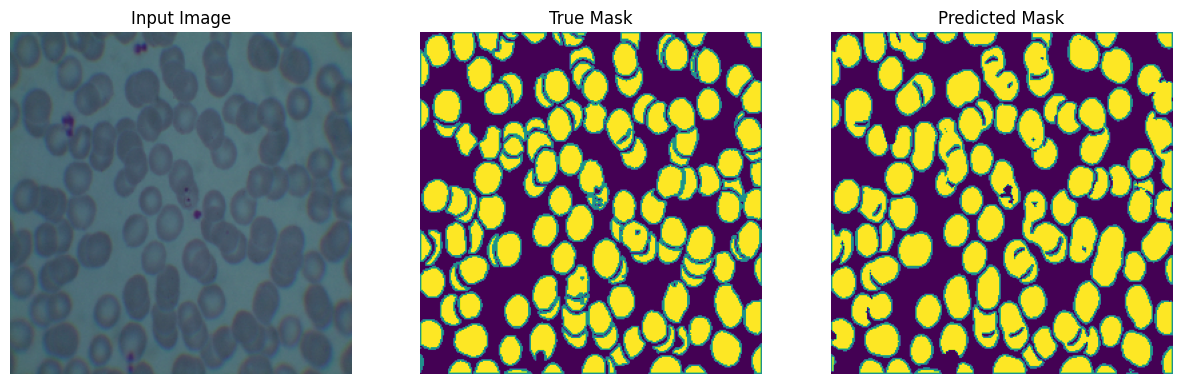

In [9]:
def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ["Input Image", "True Mask", "Predicted Mask"]
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        #plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis("off")
    plt.show()

def create_mask(pred_mask):
    #print(pred_mask)
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask
#     pred_mask2 = pred_mask.copy()
#     pred_mask2 = cv2.cvtColor(pred_mask, cv2.COLOR_BGR2GRAY)
#     pred_mask2[pred_mask2 < 0.3] = 0
#     pred_mask2[np.logical_and(pred_mask2 >= 0.3, pred_mask2 <= 0.8)] = 1
#     pred_mask2[pred_mask2 > 0.8] = 2
#     pred_mask2 = pred_mask2.astype(int)
#     return pred_mask2
    
## Dataset for prediction
p_image, p_mask = train_gen.__getitem__(0); #accessed as normalised bool
pred_mask = unet_model.predict(p_image)
display([p_image[0], p_mask[0], create_mask(pred_mask[0])])